## **Appendix B - Reliable Shortest Path using Mixed-Integer Programming**

**Course:** AER1516 - Motion Planning for Robotics

**Due:** 22 April 2022

**Team:** Vishal Kanna Annand, Andrew Constantinescu, Sugumar Prabhakaran

### **Introduction**

This code here is to implent a mixed integer program (MIP) or a mixed integer linear program (MILP) to solve the spatially dependent reliable shortest path problem.  Please see Section 4 of our paper for details on the implementation.

In [1]:
# import necessary modules
import numpy as np 
import matplotlib.pyplot as plt
import networkx as nx
from scipy.stats import norm
from math import sqrt

# install gurobi industrial MIP solver
!pip install gurobipy
import gurobipy as gp

     |████████████████████████████████| 11.5 MB 5.7 MB/s 


In [2]:
# ****INPUT YOUR OWN ACADEMIC LICENSE grbgetkey****

# Create environment with WLS license
e = gp.Env(empty=True)
# e.setParam('WLSACCESSID', 'XXXXXXXX-XXXX-XXXX-XXXX-XXXXXXXXXXXXX')
# e.setParam('WLSSECRET', 'XXXXXXXX-XXXX-XXXX-XXXX-XXXXXXXXXXXXX')
# e.setParam('LICENSEID', XXXXXX)

e.start()

# Create the model within the Gurobi environment
model = gp.Model(env=e)

Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID
Academic license - for non-commercial use only - registered to s.prabhakaran@mail.utoronto.ca


### **Mathematical Formulation**

**User Defined Parameters**
* $N$: set of nodes, with $N = \{1, 2, ..., n\}$
* $A$: set of arcs, with $A = \{a_{ij},...\}$, where $a_{ij}$: link from node $i$ to node $j$
* $T_{ij} = (t_{ij}, \sigma_{ij})$:  the normal distribution (mean, std deviation) of travel time for link $a_{ij}$
* $r, s$: start and end nodes respectively 
* $\alpha$: User defined confidence level ($\alpha> 0.5$: risk-averse, $\alpha=0.5$: risk-neutral, $\alpha < 0.5$: risk-seeking)

**Decision Variables**
* $x_{ij} \in \{0,1\}$: binary decision variable signifying link-path incidence - i.e. if link is on path = 1
* $y_{ab}$: binary decision variable that means link $a \in A$ connects to link $b \in A$

**Objective Function**
* $\Phi^{-1}(\alpha) = \sum_{a_{ij} \in A}t_{ij}\cdot x_{ij} + z_{\alpha}\cdot \sqrt{\sum_{a_{ij} \in A}(\sigma_a)^2 \cdot x_{ij} + 2\cdot \sum_{a_{ij} \in A}\sum_{b_{kl} \in A}(\sigma_{ab}\cdot y_{ab})}$, where:
* $\Phi^{-1}(\alpha)$: is the inverse cumulative density function (cdf) of the overall path travel time that we want to minimize as a function of $\alpha$
* $z_{\alpha}$: Is the inverse cdf of a standard normal distribution at a $\alpha$ confidence level
* $(\sigma_a)^2$: variance of link $a_{ij}$
* $\sigma_{ab} = $: covariance between link $a_{ij}$ and link $b_{kl}$


In [3]:
# USER DEFINED PARAMETERS
scenario = 2

if scenario == 1:
    n = 5               # number of nodes
    r = 1               # start node
    s = 5               # finish node

    N = [i for i in range(1, n+1)]                      # Set of nodes
    A = [(1,2), (1,3), (1,4), (2,3), (3,5), (4,5)]      # Set of arcs
    A_w = [(1,2, 2), (1,3, 3), (1,4, 4), (2,3, 2), (3,5, 4), (4,5, 4)] # incl wts
    t_ij = {(i,j):k for (i,j,k) in A_w}                 # dict of mean time for arc
    idx = {(j,k):i for i, (j,k) in enumerate(A)}    # index needed for dict later

    cov_matrix = np.array([[ 2.0, 0.0, 0.0, 0.0, 0.0, 0.0],
                        [-1.0, 1.0, 0.0, 0.0, 0.0, 0.0],
                        [-1.0,-0.5, 1.0, 0.0, 0.0, 0.0],
                        [ 2.0,-1.0,-0.3, 2.0, 0.0, 0.0],
                        [ 0.3, 1.5,-0.4, 2.0, 6.0, 0.0],
                        [-0.2,-0.6, 0.5,-0.4,-1.5, 1.0]])
    
    positions = {1:[1,3], 2:[3,4], 3:[3,3], 4:[3,2], 5:[5,3]} #for visualization
                   
elif scenario == 2:
    n = 14              # number of nodes
    r = 1               # start node
    s = 14              # finish node

    N = [i for i in range(1, n+1)]                              # Set of nodes
    A = [(1, 2), (1, 3), (1, 4), (2, 5), (2, 6), (3, 5), (3, 6),# Set of arcs
         (3, 7), (4, 6), (4, 7), (5, 8), (6, 9), (7, 9), (8, 10), 
         (9, 11), (11, 10), (10, 12), (10, 13), (11, 13), (12, 14), (13, 14)]   
    A_w = [(1, 2, 3), (1, 3, 1), (1, 4, 1), (2, 5, 2), (2, 6, 3), # incl wts
           (3, 5, 2),(3, 6, 7), (3, 7, 1), (4, 6, 7), (4, 7, 3), (5, 8, 5), 
           (6, 9, 1), (7, 9, 6), (8, 10, 4), (9, 11, 2), (11, 10, 2),
           (10, 12, 1), (10, 13, 2), (11, 13, 1),(12, 14, 1), (13, 14, 4)] 
    t_ij = {(i,j):k for (i,j,k) in A_w}                 # dict of mean time for arc
    idx = {(j,k):i for i, (j,k) in enumerate(A)}    # index needed for dict later

    cov_matrix = np.array([[  2,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,    0,   0,   0,   0,   0,   0,   0,   0,   0],
                           [  1, 0.1,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,    0,   0,   0,   0,   0,   0,   0,   0,   0],
                           [  1,   2,   6,   0,   0,   0,   0,   0,   0,   0,   0,   0,    0,   0,   0,   0,   0,   0,   0,   0,   0],
                           [  0,   0,   0, 0.5,   0,   0,   0,   0,   0,   0,   0,   0,    0,   0,   0,   0,   0,   0,   0,   0,   0],
                           [  0,   0,   0,   0,   2,   0,   0,   0,   0,   0,   0,   0,    0,   0,   0,   0,   0,   0,   0,   0,   0],
                           [  0,   0,   0,   0,   0, 0.2,   0,   0,   0,   0,   0,   0,    0,   0,   0,   0,   0,   0,   0,   0,   0],
                           [  0,   0,   0,   0,   0,   0,   1,   0,   0,   0,   0,   0,    0,   0,   0,   0,   0,   0,   0,   0,   0],
                           [  0,   0,   0,   0,   0,   0,   0, 0.1,   0,   0,   0,   0,    0,   0,   0,   0,   0,   0,   0,   0,   0],
                           [  2,   2,   2,   2,   2,   2,   2,   2,   9,   0,   0,   0,    0,   0,   0,   0,   0,   0,   0,   0,   0],
                           [  0,   0,   0,   0,   0,   0,   0,   0,   0,   1,   0,   0,    0,   0,   0,   0,   0,   0,   0,   0,   0],
                           [  9,   9,   9,   9,   9,   9,   9,   9,   9,   9,   2,   0,    0,   0,   0,   0,   0,   0,   0,   0,   0],
                           [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   3,    0,   0,   0,   0,   0,   0,   0,   0,   0],
                           [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,  0.7,   0,   0,   0,   0,   0,   0,   0,   0],
                           [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,    0,   1,   0,   0,   0,   0,   0,   0,   0],
                           [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,    0,   0,   2,   0,   0,   0,   0,   0,   0],
                           [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,    0,   0,   0,   1,   0,   0,   0,   0,   0],
                           [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,    0,   0,   0,   0,   1,   0,   0,   0,   0],
                           [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,    0,   0,   0,   0,   0, 0.5,   0,   0,   0],
                           [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,    0,   0,   0,   0,   0,   0, 0.2,   0,   0],
                           [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,    0,   0,   0,   0,   0,   0,   0,   1,   0],
                           [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,    0,   0,   0,   0,   0,   0,   0,   0, 0.1]])

    positions = {1:[1,3], 2:[3,4], 3:[3,3], 4:[3,2],    # for visualization
                 5:[5,4], 6:[6,3], 7:[5,2], 8:[7,3.5], 9:[7,2.5], 
                 10:[10, 3.5], 11:[8.5,2.5], 12:[12, 3.5], 13:[11,2.5],
                 14:[14, 3]}   


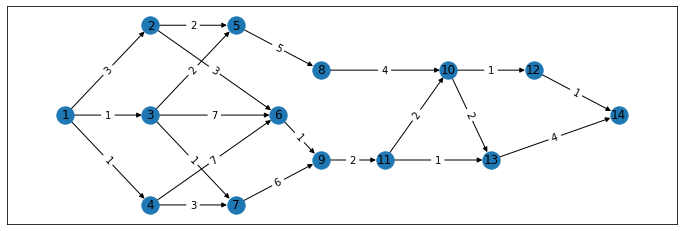

In [4]:
# VISUALIZE DIRECTED GRAPH

# create graph object and add nodes and edges with weights
plt.figure(figsize=(12,4))
G = nx.DiGraph()                
G.add_nodes_from(N)
G.add_weighted_edges_from(A_w)

# draw network
nx.draw_networkx(G, positions, with_labels=True)
nx.draw_networkx_edge_labels(G, pos=positions, edge_labels=t_ij)
plt.savefig('primal_network.png', dpi=600)
plt.show()

In [50]:
# INITIALIZE GUROBI MIP MODEL
model = gp.Model("reliable_shortest_path")
model.setParam('TimeLimit', 60) # seconds
model.Params.LogToConsole = 0   # suppress outputs

Set parameter TimeLimit to value 60


In [51]:
def optimize_model(alpha, N, A, r, s, t_ij, idx, cov_matrix):
    '''
    FUNCTION: given a network graph (N, A) problem and alpha confidence level, 
    construct a mixed-integer programming model in gurobi and return the most
    reliable path and the objective function value (inverse cdf of the path 
    travel-time)

    INPUTS:
    alpha (float)       - confidence between [0, 1], where: 0.5 is risk-neutral, 
                          <0.5 is risk-seeking and >0.5 is risk-averse
    N (list)            - list of nodes
    A (list)            - list of links (Ex. a_ij is link from node i to j)
    r (int)             - start node
    s (int)             - goal node
    t_ij (dict)         - dict of mean travel-time for each link a_ij
    idx (dict)          - dict of covariance matrix index for each link a_ij
    cov_matrix (array)  - numpy array containing var, covariance of all links
                          
    OUTPUTS:
    opt_reliable_path (list) - sequence of links from start node to goal node
    obj_val (float)          - objective function value
    '''

    z = norm.ppf(alpha) # inv. cdf of std norm. distr at alpha confidence

    # DECISION VARIABLES
    x = model.addVars(A, vtype=gp.GRB.BINARY)   # link-path incidence variables

    # additional variables to linearize objective function
    var = model.addVar(name='var')
    covariance = model.addVar(name='covariance')
    path_var = model.addVar(name='path_var')
    path_std = model.addVar(name='path_std')

    # CONSTRAINTS
    #enforce one-way direction of links from node i to node j for all links
    model.addConstrs(gp.quicksum(x[i,j] for j in G.successors(i))-
                    gp.quicksum(x[k,i] for k in G.predecessors(i)) == 1 
                    for i in N if i == r)
    model.addConstrs(gp.quicksum(x[i,j] for j in G.successors(i))-
                    gp.quicksum(x[k,i] for k in G.predecessors(i)) == 0 
                    for i in N if (i != r and i != s))
    model.addConstrs(gp.quicksum(x[i,j] for j in G.successors(i))-
                    gp.quicksum(x[k,i] for k in G.predecessors(i)) == -1 
                    for i in N if i == s)

    # OBJECTIVE FUNCTION
    # objective function:  path mean + z*sqrt(var + covar)
    path_mean = gp.quicksum(t_ij[a]*x[a] for a in A)
    var = gp.quicksum(cov_matrix[idx[a],idx[a]]*x[a] for a in A)
    covariance = gp.quicksum(cov_matrix[idx[a], idx[b]]*x[a]*x[b] 
                        for a in A for b in A if a !=b)

    #linearize sqrt in objective function
    model.addConstr(path_var == var + 2*covariance)
    model.addGenConstrPow(path_var, path_std, 0.5)  # path_std = sqrt(path_var)

    model.modelSense = gp.GRB.MINIMIZE              # minimization
    model.setObjective(path_mean+z*path_std)        # objective function
    model.optimize()                                # execute

    # RESULTS
    opt_reliable_path = []                    # initialize list to store path

    # iterate through each link that is on the path
    for a in A:
        if x[a].x != 0:
            opt_reliable_path.append(a)       # store link in optimal path list
    
    obj_val = model.getObjective().getValue() # optimal obj. function value

    return opt_reliable_path, obj_val

In [52]:
# OUTPUT RESULTS

for alpha in list(np.around(np.linspace(0.05, 0.95, 19), 2)):

    opt_path, obj_val = optimize_model(alpha, N, A, r, s, t_ij, idx, cov_matrix)
    print("alpha =", alpha, ":", opt_path, obj_val)

Academic license - for non-commercial use only - registered to s.prabhakaran@mail.utoronto.ca
alpha = 0.05 : [(1, 3), (3, 5), (5, 8), (8, 10), (10, 12), (12, 14)] 3.4293457739598416
Academic license - for non-commercial use only - registered to s.prabhakaran@mail.utoronto.ca
alpha = 0.1 : [(1, 3), (3, 5), (5, 8), (8, 10), (10, 12), (12, 14)] 5.764103276693852
Academic license - for non-commercial use only - registered to s.prabhakaran@mail.utoronto.ca
alpha = 0.15 : [(1, 3), (3, 5), (5, 8), (8, 10), (10, 12), (12, 14)] 7.33935375184258
Academic license - for non-commercial use only - registered to s.prabhakaran@mail.utoronto.ca
alpha = 0.2 : [(1, 3), (3, 5), (5, 8), (8, 10), (10, 12), (12, 14)] 8.59131737703282
Academic license - for non-commercial use only - registered to s.prabhakaran@mail.utoronto.ca
alpha = 0.25 : [(1, 3), (3, 5), (5, 8), (8, 10), (10, 12), (12, 14)] 9.665388773319261
Academic license - for non-commercial use only - registered to s.prabhakaran@mail.utoronto.ca
alph